# For the Ohiot1dm

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
def load_ohio_series_train(path_filename, variate_name, attribute, time_attribue="ts"):
    tree = ET.parse(f"{path_filename}")
    root = tree.getroot()
    for child in root:
        if child.tag == variate_name:
            dates = []
            values = []
            for event in child:
                ts = event.attrib[time_attribue]
                date = pd.to_datetime(ts, format='%d-%m-%Y %H:%M:%S')
                date = date.replace(second=0)
                value = float(event.attrib[attribute])
                dates.append(date)
                values.append(value)
            index = pd.DatetimeIndex(dates)
            series = pd.Series(values, index=index)
            seriesdf = series.reset_index()

            # Rename the columns (optional)
            seriesdf.columns = ['timestamp', 'mg/dl']
            return seriesdf

In [3]:
file_path_2018 = "C:/Users/baiyi/OneDrive/Desktop/Modify_GenBG/OhioT1DM 2020/2018/combined"
file_path_2020 = "C:/Users/baiyi/OneDrive/Desktop/Modify_GenBG/OhioT1DM 2020/2020/combined"

# Get all yaml files in the directory
files_2018 = glob.glob(file_path_2018 + "/*.xml")
files_2020 = glob.glob(file_path_2020 + "/*.xml")

total_ave_cgm_list = []
total_ave_std_list = []
total_num_in_range_record_ratio_list = []
total_variation_list = []
daily_cgm_list = []
daily_std_list = []
daily_TIR_ratio_list = []
subject_list = []
daily_gly_var_list = []

all_files = files_2018 + files_2020

for file in all_files:
    seriesdf = load_ohio_series_train(file,"glucose_level", "value", time_attribue="ts")
    subject_number = os.path.basename(file).split('-')[0].replace('-ws-combined.xml', '')
    subject_list.append(subject_number)
    total_ave_cgm = seriesdf["mg/dl"].mean()
    total_ave_std = seriesdf["mg/dl"].std()
    total_variation = seriesdf["mg/dl"].var()
    total_num_in_range_record_ratio = seriesdf[(seriesdf["mg/dl"] > 70) & (seriesdf["mg/dl"] < 180)].shape[0] / seriesdf.shape[0]
    total_ave_cgm_list.append(total_ave_cgm)
    total_ave_std_list.append(total_ave_std)
    total_num_in_range_record_ratio_list.append(total_num_in_range_record_ratio)
    total_variation_list.append(total_variation)

    # Check the samping interval
    # Calculate the interval between every two nearby data points
    seriesdf['timestamp'] = pd.to_datetime(seriesdf['timestamp'])
    intervals = seriesdf['timestamp'].diff().dropna()
    # Calculate the minimum interval
    min_interval = intervals.min()
    # Calculate the most frequent interval
    most_frequent_interval = intervals.mode()[0]
    # Print the summary
    print(f"Minimum interval: {min_interval}")
    print(f"Most frequent interval: {most_frequent_interval}")

    # To calculate the daily ave, var, and TIR ratio
    seriesdf["day"] = seriesdf["timestamp"].dt.date
    daily_stats = seriesdf.groupby("day")["mg/dl"].agg(["mean", "std", "count"])
    daily_stats['gly_var'] = daily_stats['std'] *100 / daily_stats['mean']
    daily_stats["TIR_ratio"] = seriesdf[(seriesdf["mg/dl"] > 70) & (seriesdf["mg/dl"] < 180)].groupby("day").size() / daily_stats["count"]
    daily_cgm_list.append(daily_stats["mean"].mean())
    daily_std_list.append(daily_stats["std"].mean())
    daily_gly_var_list.append(daily_stats["gly_var"].mean())
    daily_TIR_ratio_list.append(daily_stats["TIR_ratio"].mean())

    


# for file_2020 in files_2020:
#     seriesdf = load_ohio_series_train(file_2020,"glucose_level", "value", time_attribue="ts")
#     print(seriesdf)

Minimum interval: 0 days 00:05:00
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:05:00
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:05:00
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:05:00
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:05:00
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:05:00
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:03:00
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:00
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:05:00
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:05:00
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:00
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:05:00
Most frequent interval: 0 days 00:05:00


In [49]:
print(daily_gly_var_list)
# print(total_ave_std_list)
# print(total_num_in_range_record_ratio_list)
# print(daily_cgm_list)
# print(daily_std_list)
# print(daily_TIR_ratio_list)

[36.878491655070675, 28.715226551071133, 27.934715505686047, 35.86184794171167, 25.562604082488104, 32.60158508058373, 33.912812408212886, 30.75380647347756, 31.039951094976985, 35.60857028316724, 28.83066560715798, 27.23140553589588]


In [51]:
# Create a DataFrame to summarize the results
summary_df = pd.DataFrame({
    'Subject': subject_list,
    'Daily CGM': daily_cgm_list,
    'Daily Std': daily_std_list,
    'Daily TIR Ratio': daily_TIR_ratio_list,
    'Daily Gly Var': daily_gly_var_list,
})

# Save the DataFrame to an Excel file
summary_df.to_excel('summary_results.xlsx', index=False)

# Print the DataFrame to verify
print(summary_df)

   Subject   Daily CGM  Daily Std  Daily TIR Ratio  Daily Gly Var
0      559  167.813030  61.619881         0.553600      36.878492
1      563  149.892192  42.943136         0.711924      28.715227
2      570  191.897947  51.427427         0.421341      27.934716
3      575  143.575371  52.091154         0.673276      35.861848
4      588  165.981246  42.381159         0.617243      25.562604
5      591  154.469428  50.012570         0.623311      32.601585
6      540  141.005020  47.557005         0.690298      33.912812
7      544  164.891588  50.576441         0.640227      30.753806
8      552  145.237494  44.824624         0.729447      31.039951
9      567  151.804963  52.848975         0.629764      35.608570
10     584  188.362951  53.820588         0.507650      28.830666
11     596  144.898296  39.983007         0.743829      27.231406


In [4]:
# Entire Glucose distribution
file_path_2018 = "C:/Users/baiyi/OneDrive/Desktop/Modify_GenBG/OhioT1DM 2020/2018/combined"
file_path_2020 = "C:/Users/baiyi/OneDrive/Desktop/Modify_GenBG/OhioT1DM 2020/2020/combined"

# Get all yaml files in the directory
files_2018 = glob.glob(file_path_2018 + "/*.xml")
files_2020 = glob.glob(file_path_2020 + "/*.xml")

total_ave_cgm_list = []
total_ave_std_list = []
total_num_in_range_record_ratio_list = []
total_variation_list = []
daily_cgm_list = []
daily_std_list = []
daily_TIR_ratio_list = []
subject_list = []
daily_gly_var_list = []

all_files = files_2018 + files_2020
ohio_cgm = []  # Initialize empty list to store all CGM values

for file in all_files:
    seriesdf = load_ohio_series_train(file,"glucose_level", "value", time_attribue="ts")
    subject_number = os.path.basename(file).split('-')[0].replace('-ws-combined.xml', '')
    subject_list.append(subject_number)
    
    # Extend ohio_cgm list with all CGM values from current file
    ohio_cgm.extend(seriesdf["mg/dl"].values.tolist())

# For the DiaTrend

In [5]:
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format="%Y-%m-%d %H:%M:%S.%f")
    except ValueError:
        try:
            return pd.to_datetime(date_str, format="%Y-%m-%d %H:%M:%S")
        except ValueError:
            return pd.NaT

def load_diatrend_series(path):
    subject = pd.read_csv(path)

    # Lists to store the results
    parsed_dates = []
    values = []

    # Iterate through each row in the DataFrame
    for index, row in subject.iterrows():
        # Parse the date using the custom function
        parsed_date = parse_date(row['date'])
        
        # Append the parsed date and corresponding value to the lists
        parsed_dates.append(parsed_date)
        values.append(float(row['mg/dl']))

    # Now 'parsed_dates' and 'values' contain your data
    # print(parsed_dates)
    # print(values)
    index = pd.DatetimeIndex(parsed_dates)
    series = pd.Series(values, index=index)
    seriesdf = series.reset_index()

    # Rename the columns (optional)
    seriesdf.columns = ['timestamp', 'mg/dl']
    
    return seriesdf

In [6]:
file_path = "C:/Users/baiyi/OneDrive/Desktop/Modify_GenBG/modified_diatrend_subset"  
# "C:\Users\baiyi\OneDrive\Desktop\Modify_GenBG\modified_diatrend_subset\processed_cgm_data_Subject1.csv"

# Get all yaml files in the directory
all_files = glob.glob(file_path + "/*.csv")


total_ave_cgm_list = []
total_ave_std_list = []
total_num_in_range_record_ratio_list = []
total_variation_list = []
daily_cgm_list = []
daily_std_list = []
daily_TIR_ratio_list = []
subject_list = []
daily_gly_var_list = []

# all_files = files_2018 + files_2020

for file in all_files:
    seriesdf = load_diatrend_series(file)
    # Extract subject number from file name
    subject_number = os.path.basename(file).split('-')[0].replace('processed_cgm_data_Subject', '')
    # Append results to lists
    subject_list.append(subject_number)
    total_ave_cgm = seriesdf["mg/dl"].mean()
    total_ave_std = seriesdf["mg/dl"].std()
    total_variation = seriesdf["mg/dl"].var()
    total_num_in_range_record_ratio = seriesdf[(seriesdf["mg/dl"] > 70) & (seriesdf["mg/dl"] < 180)].shape[0] / seriesdf.shape[0]
    total_ave_cgm_list.append(total_ave_cgm)
    total_ave_std_list.append(total_ave_std)
    total_num_in_range_record_ratio_list.append(total_num_in_range_record_ratio)
    total_variation_list.append(total_variation)

    # Check the samping interval
    # Calculate the interval between every two nearby data points
    seriesdf['timestamp'] = pd.to_datetime(seriesdf['timestamp'])
    intervals = seriesdf['timestamp'].diff().dropna()
    # Calculate the minimum interval
    min_interval = intervals.min()
    # Calculate the most frequent interval
    most_frequent_interval = intervals.mode()[0]
    # Print the summary
    print(f"Minimum interval: {min_interval}")
    print(f"Most frequent interval: {most_frequent_interval}")

    # To calculate the daily ave, var, and TIR ratio
    seriesdf["day"] = seriesdf["timestamp"].dt.date
    daily_stats = seriesdf.groupby("day")["mg/dl"].agg(["mean", "std", "count"])
    daily_stats['gly_var'] = daily_stats['std'] *100 / daily_stats['mean']
    daily_stats["TIR_ratio"] = seriesdf[(seriesdf["mg/dl"] > 70) & (seriesdf["mg/dl"] < 180)].groupby("day").size() / daily_stats["count"]
    daily_cgm_list.append(daily_stats["mean"].mean())
    daily_std_list.append(daily_stats["std"].mean())
    daily_gly_var_list.append(daily_stats["gly_var"].mean())
    daily_TIR_ratio_list.append(daily_stats["TIR_ratio"].mean())

    


# for file_2020 in files_2020:
#     seriesdf = load_ohio_series_train(file_2020,"glucose_level", "value", time_attribue="ts")
#     print(seriesdf)

Minimum interval: 0 days 00:04:37.197000
Most frequent interval: 0 days 00:04:59.677000
Minimum interval: 0 days 00:04:58
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:58
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:47
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:58
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:57
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:58
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:46
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:58
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:51
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:54
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:38.886000
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:14
Most frequent interval: 0 days 00:05:00
Minimum interval:

In [55]:
# Create a DataFrame to summarize the results
summary_df = pd.DataFrame({
    'Subject': subject_list,
    'Daily CGM': daily_cgm_list,
    'Daily Std': daily_std_list,
    'Daily TIR Ratio': daily_TIR_ratio_list,
    'Daily_gly_var': daily_gly_var_list
})

# Save the DataFrame to an Excel file
summary_df.to_excel('diatrend_summary_results.xlsx', index=False)

# Print the DataFrame to verify
print(summary_df)

   Subject   Daily CGM  Daily Std  Daily TIR Ratio  Daily_gly_var
0    1.csv  175.129056  54.243217         0.511142      31.504664
1   10.csv  207.592940  68.487150         0.395920      34.362107
2   11.csv  187.110596  64.425797         0.454250      34.924640
3   12.csv  196.642063  67.663691         0.453222      34.840760
4   13.csv  130.530575  33.877595         0.884827      25.785695
5   14.csv  308.722090  67.192701         0.171243      23.153243
6   15.csv  171.558458  61.014662         0.545693      35.785926
7   16.csv  242.841267  85.370093         0.302992      35.840493
8   17.csv  225.138873  57.247669         0.246033      25.775770
9   18.csv  176.956862  57.416681         0.502472      32.933922
10  19.csv  235.346362  63.312181         0.294171      27.561401
11   2.csv  184.025336  57.970295         0.494938      32.148566
12  20.csv  181.885710  57.334330         0.521647      31.486304
13  21.csv  135.089334  37.881552         0.837346      28.107392
14  22.csv

In [7]:
file_path = "C:/Users/baiyi/OneDrive/Desktop/Modify_GenBG/modified_diatrend_subset"  
# "C:\Users\baiyi\OneDrive\Desktop\Modify_GenBG\modified_diatrend_subset\processed_cgm_data_Subject1.csv"

# Get all yaml files in the directory
all_files = glob.glob(file_path + "/*.csv")


# all_files = files_2018 + files_2020
diatrend_cgm = []
for file in all_files:
    seriesdf = load_diatrend_series(file)
    diatrend_cgm.extend(seriesdf["mg/dl"].values.tolist())

# For T1DEXI

In [8]:
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format="%Y-%m-%d %H:%M:%S.%f")
    except ValueError:
        try:
            return pd.to_datetime(date_str, format="%Y-%m-%d %H:%M:%S")
        except ValueError:
            return pd.NaT

def load_T1DEXI_series(path):
    subject = pd.read_csv(path)

    # Lists to store the results
    parsed_dates = []
    values = []

    # Iterate through each row in the DataFrame
    for index, row in subject.iterrows():
        # Parse the date using the custom function
        parsed_date = parse_date(row['LBDTC'])
        
        # Append the parsed date and corresponding value to the lists
        parsed_dates.append(parsed_date)
        values.append(float(row['LBORRES']))

    # Now 'parsed_dates' and 'values' contain your data
    # print(parsed_dates)
    # print(values)
    index = pd.DatetimeIndex(parsed_dates)
    series = pd.Series(values, index=index)
    
    seriesdf = series.reset_index()

    # Rename the columns (optional)
    seriesdf.columns = ['timestamp', 'mg/dl']
    
    return seriesdf

In [57]:
file_path = "C:/Users/baiyi/OneDrive/Desktop/Modify_GenBG/modified_t1dexi_subset/T1DEXI_cgm_processed"  
# "C:\Users\baiyi\OneDrive\Desktop\Modify_GenBG\modified_t1dexi_subset\T1DEXI_cgm_processed\1.csv"

# Get all yaml files in the directory
all_files = glob.glob(file_path + "/*.csv")


total_ave_cgm_list = []
total_ave_std_list = []
total_num_in_range_record_ratio_list = []
total_variation_list = []
daily_cgm_list = []
daily_std_list = []
daily_TIR_ratio_list = []
subject_list = []
daily_gly_var_list = []

# all_files = files_2018 + files_2020

for file in all_files:
    seriesdf = load_T1DEXI_series(file)
    # Extract subject number from file name
    subject_number = os.path.basename(file).split('-')[0].replace('.csv', '')
    # Append results to lists
    subject_list.append(subject_number)
    total_ave_cgm = seriesdf["mg/dl"].mean()
    total_ave_std = seriesdf["mg/dl"].std()
    total_variation = seriesdf["mg/dl"].var()
    total_num_in_range_record_ratio = seriesdf[(seriesdf["mg/dl"] > 70) & (seriesdf["mg/dl"] < 180)].shape[0] / seriesdf.shape[0]
    total_ave_cgm_list.append(total_ave_cgm)
    total_ave_std_list.append(total_ave_std)
    total_num_in_range_record_ratio_list.append(total_num_in_range_record_ratio)
    total_variation_list.append(total_variation)

    # Check the samping interval
    # Calculate the interval between every two nearby data points
    seriesdf['timestamp'] = pd.to_datetime(seriesdf['timestamp'])
    intervals = seriesdf['timestamp'].diff().dropna()
    # Calculate the minimum interval
    min_interval = intervals.min()
    # Calculate the most frequent interval
    most_frequent_interval = intervals.mode()[0]
    # Print the summary
    print(f"Minimum interval: {min_interval}")
    print(f"Most frequent interval: {most_frequent_interval}")

    # To calculate the daily ave, var, and TIR ratio
    # To calculate the daily ave, var, and TIR ratio
    seriesdf["day"] = seriesdf["timestamp"].dt.date
    daily_stats = seriesdf.groupby("day")["mg/dl"].agg(["mean", "std", "count"])
    daily_stats['gly_var'] = daily_stats['std'] *100 / daily_stats['mean']
    daily_stats["TIR_ratio"] = seriesdf[(seriesdf["mg/dl"] > 70) & (seriesdf["mg/dl"] < 180)].groupby("day").size() / daily_stats["count"]
    daily_cgm_list.append(daily_stats["mean"].mean())
    daily_std_list.append(daily_stats["std"].mean())
    daily_gly_var_list.append(daily_stats["gly_var"].mean())
    daily_TIR_ratio_list.append(daily_stats["TIR_ratio"].mean())

    


# for file_2020 in files_2020:
#     seriesdf = load_ohio_series_train(file_2020,"glucose_level", "value", time_attribue="ts")
#     print(seriesdf)

Minimum interval: 0 days 00:04:52
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:39
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:58
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:58
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:51
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:43
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:49
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:41
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:36
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:56
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:35
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:58
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:04:58
Most frequent interval: 0 days 00:05:00
Minimum interval: 0 days 00:00:46
Most

In [58]:
# Create a DataFrame to summarize the results
summary_df = pd.DataFrame({
    'Subject': subject_list,
    'Daily CGM': daily_cgm_list,
    'Daily Std': daily_std_list,
    'Daily TIR Ratio': daily_TIR_ratio_list,
    'Daily_gly_var': daily_gly_var_list
})

# Save the DataFrame to an Excel file
summary_df.to_excel('t1dexi_summary_results.xlsx', index=False)

# Print the DataFrame to verify
print(summary_df)

   Subject   Daily CGM  Daily Std  Daily TIR Ratio  Daily_gly_var
0        1  160.353862  52.608522         0.612843      33.673801
1     1010  133.785876  49.617530         0.709269      36.769508
2     1015  138.686615  28.438973         0.872997      20.522697
3      103  123.802330  28.506241         0.919914      22.980246
4     1043  138.311754  37.539774         0.837127      26.907439
..     ...         ...        ...              ...            ...
58     187  165.676922  56.170967         0.579540      33.860858
59      24  129.696617  44.741544         0.775603      34.394383
60     248  114.386635  33.646761         0.830211      29.165355
61      25  218.007534  45.502344         0.285046      21.268358
62     252  121.138438  31.506968         0.912975      25.801714

[63 rows x 5 columns]


In [9]:
file_path = "C:/Users/baiyi/OneDrive/Desktop/Modify_GenBG/modified_t1dexi_subset/T1DEXI_cgm_processed"  
# "C:\Users\baiyi\OneDrive\Desktop\Modify_GenBG\modified_t1dexi_subset\T1DEXI_cgm_processed\1.csv"

# Get all yaml files in the directory
all_files = glob.glob(file_path + "/*.csv")

t1dexi_cgm = []
for file in all_files:
    seriesdf = load_T1DEXI_series(file)
    t1dexi_cgm.extend(seriesdf["mg/dl"].values.tolist())

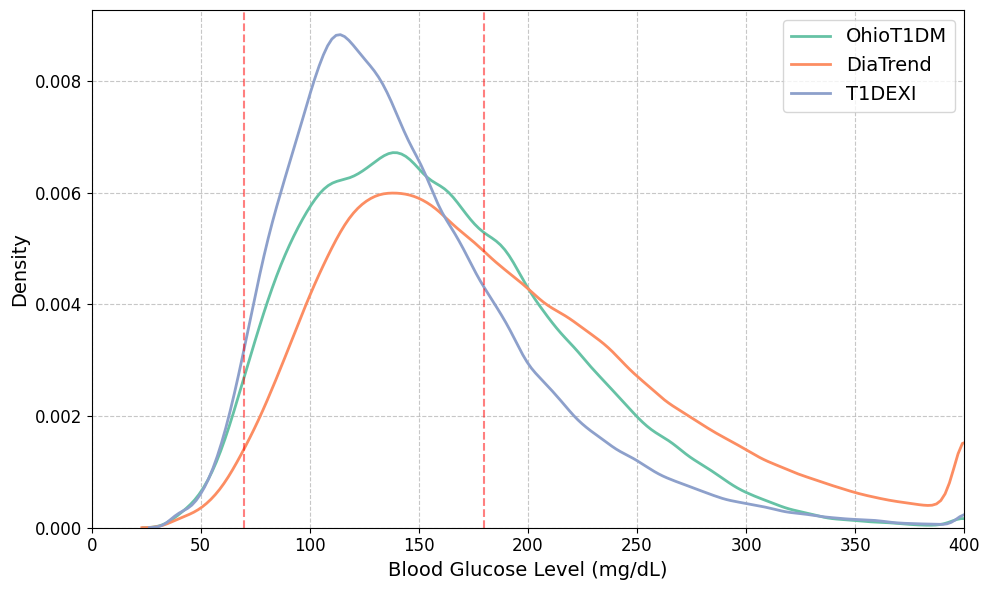

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set figure style and size
# plt.style.use('seaborn')
plt.figure(figsize=(10, 6))

# Plot density distributions
sns.kdeplot(data=ohio_cgm, label='OhioT1DM', color='#66c2a5', linewidth=2)
sns.kdeplot(data=diatrend_cgm, label='DiaTrend', color='#fc8d62', linewidth=2)
sns.kdeplot(data=t1dexi_cgm, label='T1DEXI', color='#8da0cb', linewidth=2)

# Customize the plot
plt.xlabel('Blood Glucose Level (mg/dL)', fontsize=14)
plt.ylabel('Density', fontsize=14)
# plt.title('Distribution of CGM Values Across Datasets')
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis limits to focus on clinically relevant range
plt.xlim(0, 400)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add vertical lines for important glucose thresholds
plt.axvline(x=70, color='red', linestyle='--', alpha=0.5, label='Hypoglycemia threshold')
plt.axvline(x=180, color='red', linestyle='--', alpha=0.5, label='Hyperglycemia threshold')

plt.tight_layout()
plt.show()

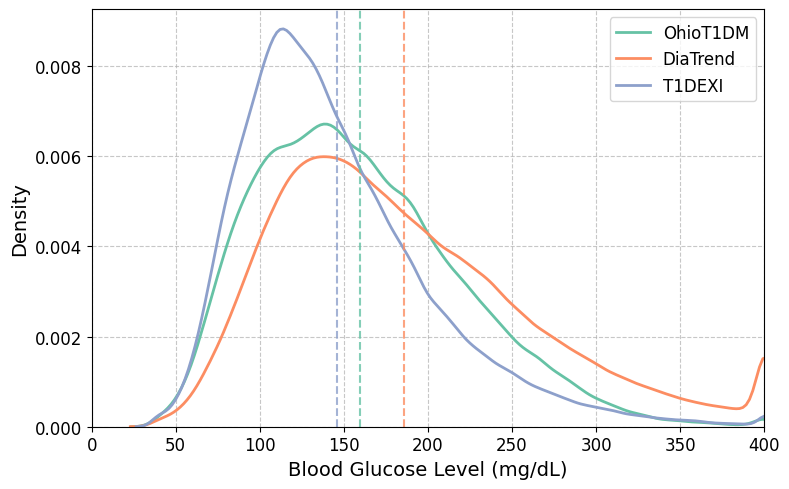

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set figure style and size
# plt.style.use('seaborn')
plt.figure(figsize=(8, 5))

# Calculate means
ohio_mean = np.mean(ohio_cgm)
diatrend_mean = np.mean(diatrend_cgm)
t1dexi_mean = np.mean(t1dexi_cgm)

# Plot density distributions
sns.kdeplot(data=ohio_cgm, label='OhioT1DM', color='#66c2a5', linewidth=2)
sns.kdeplot(data=diatrend_cgm, label='DiaTrend', color='#fc8d62', linewidth=2)
sns.kdeplot(data=t1dexi_cgm, label='T1DEXI', color='#8da0cb', linewidth=2)

# Add vertical lines for means with annotations
plt.axvline(x=ohio_mean, color='#66c2a5', linestyle='--', alpha=0.8)
plt.axvline(x=diatrend_mean, color='#fc8d62', linestyle='--', alpha=0.8)
plt.axvline(x=t1dexi_mean, color='#8da0cb', linestyle='--', alpha=0.8)

# Add mean value annotations
# plt.text(ohio_mean, plt.gca().get_ylim()[1], f'OhioT1DM Mean', 
#          color='#66c2a5', ha='right', va='top')
# plt.text(diatrend_mean, plt.gca().get_ylim()[1]*0.9, f'DiaTrend Mean', 
#          color='#fc8d62', ha='right', va='top')
# plt.text(t1dexi_mean, plt.gca().get_ylim()[1]*0.8, f'T1DEXI Mean', 
#          color='#8da0cb', ha='right', va='top')

# Customize the plot
plt.xlabel('Blood Glucose Level (mg/dL)', fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Distribution of CGM Values Across Datasets')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 400)

plt.tight_layout()
plt.show()